In [29]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from features.ifp_similarity import merge_hbonds

from tqdm import tqdm

ifp_csv_list = "/home/pc/Documents/combind_fragment/combind_fragment/fragment_dataset_redocking/*/docking/*/*_ifp_rd1.csv"
ifp_csv_list = glob.glob(ifp_csv_list)


rmsd_list = "/home/pc/Documents/combind_fragment/combind_fragment/fragment_dataset_redocking/*/docking/*/*_rmsd.npy"
rmsd_list = glob.glob(rmsd_list)

#align the rmsd list and ifp csv list by the path directory. in alignment remove the last part of the path, but keep the last part of the file name
def align_list(rmsd_list, ifp_csv_list):
    # Get the base directories by removing the last part of the path
    rmsd_base = [os.path.dirname(f) for f in rmsd_list]
    ifp_base = [os.path.dirname(f) for f in ifp_csv_list]
    
    # Create dictionaries mapping base dirs to full paths
    rmsd_dict = dict(zip(rmsd_base, rmsd_list))
    ifp_dict = dict(zip(ifp_base, ifp_csv_list))
    
    # Find common base directories
    common_bases = set(rmsd_base) & set(ifp_base)
    
    # Create aligned lists using common bases
    rmsd_list = [rmsd_dict[base] for base in common_bases]
    ifp_csv_list = [ifp_dict[base] for base in common_bases]
    return rmsd_list, ifp_csv_list

rmsd_list, ifp_csv_list = align_list(rmsd_list, ifp_csv_list)




In [30]:
ifp_csv_list = [pd.read_csv(f) for f in ifp_csv_list]
rmsd_list = [np.load(f) for f in rmsd_list]
#keep top 100 for rmsd
rmsd_list = [i[:100] for i in rmsd_list]

#remove list with rmsd value less than 0, also remove the corresponding ifp csv
# Filter out lists where all RMSD values are less than 0
valid_indices = [i for i, rmsd in enumerate(rmsd_list) if any(rmsd >= 0)]
rmsd_list = [rmsd_list[i] for i in valid_indices]
ifp_csv_list = [ifp_csv_list[i] for i in valid_indices]



In [34]:
scores_list = []
features = ["hbond", "contact", "saltbridge"]
for ifp, rmsd in tqdm(zip(ifp_csv_list, rmsd_list), total=len(ifp_csv_list)):
    ifp_csv_grouped = ifp.groupby('pose')
    scores = {feature: [] for feature in features}
    for feature in features:
        for i, pose in ifp_csv_grouped:
            if feature == "hbond":
                pose = merge_hbonds(pose)
            #filter by feature
            pose = pose[pose['label'] == feature]
            #get the score
            scores[feature] += [pose['score'].sum()]
    
            
    scores_list.append(scores)
            

100%|██████████| 229/229 [00:44<00:00,  5.16it/s]


In [35]:
scores_dict = {"hbond": [], "contact": [], "saltbridge": []}
for scores in scores_list:
    for feature in features:
        scores_dict[feature] += scores[feature]
#stack rmsd list
rmsd_total = np.concatenate(rmsd_list)

/tmp/ipykernel_3407667/3300558611.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(score_feature_rmsd_gt_2, label=feature + ' rmsd > 2', shade=True)
/tmp/ipykernel_3407667/3300558611.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(score_feature_rmsd_le_2, label=feature + ' rmsd <= 2', shade=True)


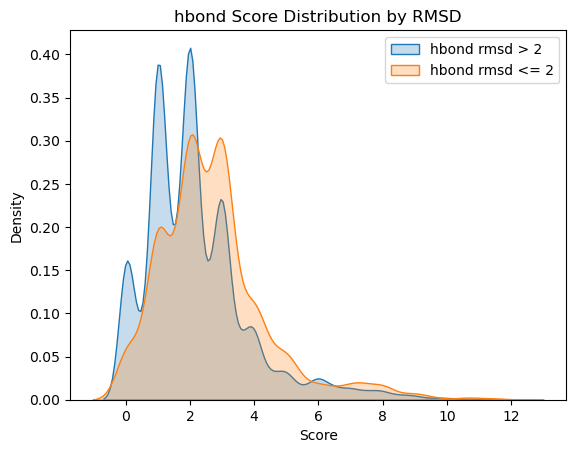

/tmp/ipykernel_3407667/3300558611.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(score_feature_rmsd_gt_2, label=feature + ' rmsd > 2', shade=True)
/tmp/ipykernel_3407667/3300558611.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(score_feature_rmsd_le_2, label=feature + ' rmsd <= 2', shade=True)


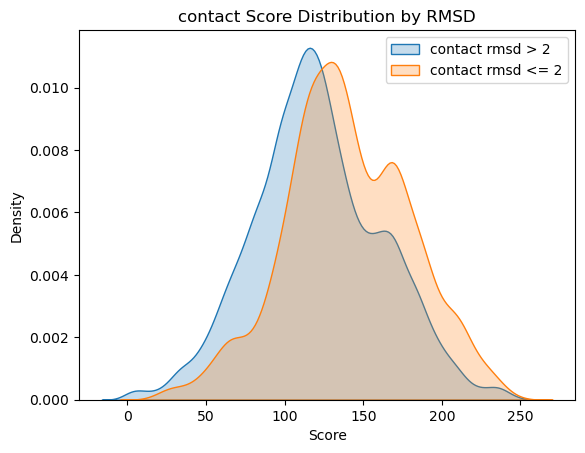

/tmp/ipykernel_3407667/3300558611.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(score_feature_rmsd_gt_2, label=feature + ' rmsd > 2', shade=True)
/tmp/ipykernel_3407667/3300558611.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(score_feature_rmsd_le_2, label=feature + ' rmsd <= 2', shade=True)


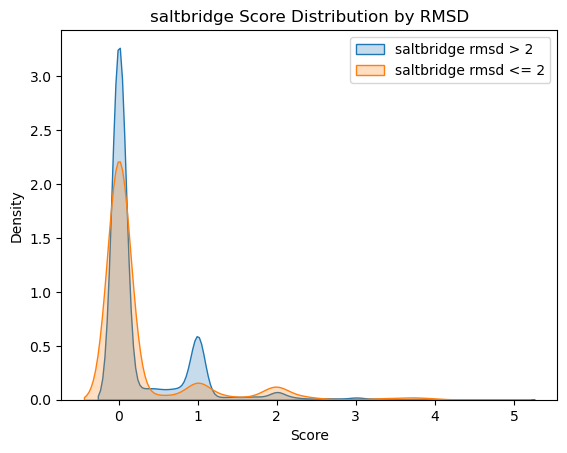

In [39]:
#plot the histograms of the scores_dict for each feature. For each feature, seperate the score by rmsd > 2 and rmsd <= 2
for feature in features:
    score_feature = scores_dict[feature]
    score_feature = np.array(score_feature)
    score_feature_rmsd_gt_2 = score_feature[rmsd_total>2]
    score_feature_rmsd_le_2 = score_feature[rmsd_total<=2]
    # plt.hist(score_feature_rmsd_gt_2, bins=100, alpha=0.5, label=feature + ' rmsd > 2', density=True)
    # plt.hist(score_feature_rmsd_le_2, bins=100, alpha=0.5, label=feature + ' rmsd <= 2', density=True)
    # plt.legend()
    # plt.show()
    
    #plot kernel density estimation
    sns.kdeplot(score_feature_rmsd_gt_2, label=feature + ' rmsd > 2', shade=True)
    sns.kdeplot(score_feature_rmsd_le_2, label=feature + ' rmsd <= 2', shade=True)
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(feature + ' Score Distribution by RMSD')
    plt.legend()
    plt.show()
